<h1>Deep Reinforcement Learning</h1>
<h3> Multi Armed bandit Algorithm</h3>

<h5>SHARAT KN </h5>


Problem Statement:
You are a data scientist working in cancer research, collaborating with a medical institution that conducts clinical trials for different treatment protocols. The objective is to optimize the allocation of resources (Research time, and funding) across diverse treatment arms within breast cancer clinical trials. The primary goal is to identify the most efficacious and personalized treatment strategies while minimizing resource expenditure and expediting the development of effective treatments for cancer patients.

IMPORTING DATASET AND PREPROCESSING

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces

In [19]:
cancer_ds = pd.read_csv("cancer.csv")
cancer_ds.head(2) #display first 2 rows of the dataframe

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,Treatment Type,"Treatment status(0=Failure,1=Success)",budget(in dollars),Time(In days)
0,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,Chemotherapy,1,16442,224
1,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,Surgery,1,40967,324


In [20]:
cancer_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   diagnosis                              569 non-null    object 
 1   radius_mean                            569 non-null    float64
 2   texture_mean                           569 non-null    float64
 3   perimeter_mean                         569 non-null    float64
 4   area_mean                              569 non-null    float64
 5   smoothness_mean                        569 non-null    float64
 6   compactness_mean                       569 non-null    float64
 7   concavity_mean                         569 non-null    float64
 8   concave points_mean                    569 non-null    float64
 9   symmetry_mean                          569 non-null    float64
 10  fractal_dimension_mean                 569 non-null    float64
 11  Treatm

No null values observed. The dataset is clean for further processing

Tumor Details are not relevant for our research. Hence, we are dropping those details from the dataset

In [21]:
cancer = cancer_ds.drop(columns=['radius_mean', 'texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean'])
cancer.head(2)

,diagnosis,Treatment Type,"Treatment status(0=Failure,1=Success)",budget(in dollars),Time(In days)
0,M,Chemotherapy,1,16442,224
1,M,Surgery,1,40967,324


We are keeping only those variables which are required to make the selection of efficient Treatment Process - Type of Cancer, Treatment Type, Treatment Status, Budget, Time the treatment process took

<h3> Implement the Multi-Armed Bandit algorithm (Epsilon-Greedy) using OPENAI GYM</h3>

In [22]:
class CancerTreatmentEnv(gym.Env):
    def __init__(self, data):
        super(CancerTreatmentEnv, self).__init__()

        self.data = data
        self.treatment_types = np.unique(data['Treatment Type'])
        self.num_actions = len(self.treatment_types)
        self.action_space = spaces.Discrete(self.num_actions)

        self.current_episode = 0

    def step(self, action):
        # Execute action and get reward
        chosen_treatment = self.treatment_types[action]
        
        #Filter all the rows with the Treatment Type specified
        filtered_row = self.data[self.data['Treatment Type'] == chosen_treatment]
        #Selecting a random Patient from the filtered Treatment Type category
        random_row = filtered_row.sample(n=1, random_state=None)

        reward = calculate_reward(random_row['diagnosis'].iloc[0], chosen_treatment, random_row['budget(in dollars)'].iloc[0], random_row['Time(In days)'].iloc[0], random_row['Treatment status(0=Failure,1=Success)'].iloc[0])

        # Increment episode counter
        self.current_episode += 1

        return None, reward, False, {}  # Observation is None, no termination condition defined

    def reset(self):
        return None  # Observation is None

    def render(self, mode='human'):
        pass

    def close(self):
        pass

Epsilon-greedy is a strategy in reinforcement learning where an agent explores randomly with probability ε, and exploits the best-known action with probability 1-ε, balancing exploration and exploitation.

In [23]:
class EpsilonGreedy:
    def __init__(self, epsilon, num_actions):
        self.epsilon = epsilon
        self.num_actions = num_actions
        self.action_counts = np.zeros(num_actions)
        self.q_values = np.zeros(num_actions)
        self.exploration_count = 0  # Initialize exploration count
        self.exploitation_count = 0  # Initialize exploitation count
        self.total_reward = 0

    def choose_action(self):
        if np.random.random() < self.epsilon:
            # Exploration: Choose a random action
            action = np.random.randint(self.num_actions)
            self.exploration_count += 1  # Increment exploration count
        else:
            # Exploitation: Choose action with highest Q-value
            action = np.argmax(self.q_values)
            self.exploitation_count += 1  # Increment exploitation count
        return action
        

    def update(self, action, reward):
        self.action_counts[action] += 1
        self.q_values[action] += (reward - self.q_values[action]) / self.action_counts[action]
        self.total_reward += reward


Defining Rewards

In [24]:
def calculate_reward(cancer_type, treatment_type, budget, time, success):
    # Reward based on cancer type
    type_reward = 1 if cancer_type == 'M' else 0.5  # Assuming Malignant holds higher value

    # Reward based on time (less time holds higher value)
    time_reward = 1 / (1 + time) 

    # Reward based on budget (less budget preferred)
    budget_reward = 1 / (1 + budget) 

    # Reward based on success rate (0 - failure, no reward at all)
    success_reward = success 

    # Combine rewards using weighted sum or any other suitable method
    returns = 0.4 * success_reward + 0.25 * time_reward + 0.25 * budget_reward + 0.1 * type_reward

    return returns

 type_reward: Assigns a higher reward (1) if the cancer type is malignant and a lower reward (0.5) if it's benign.<br>
 time_reward: Assigns a higher reward for treatments that take less time.<br>
 budget_reward: Assigns a higher reward for treatments with lower budgets.<br>
 success_reward: Assigns a reward based on the success rate, with successful treatments receiving a reward of 1 and unsuccessful treatments receiving a reward of 0. This parameter holds the heighest weightage while calculating returns<br>
 
 total_reward: Combines the rewards using a weighted sum, with weights chosen based on their relative importance.

In [25]:
# Instantiating the environment
env = CancerTreatmentEnv(cancer)

In [26]:
#Instantiating the MAB Agent
epsilon = 0.1  # Epsilon value for epsilon-greedy algorithm
mab = EpsilonGreedy(epsilon, env.num_actions)

<h3>Train the MAB model</h3>

In [27]:
q_values_over_episodes = []
# Training loop
num_episodes = 1000  # Number of episodes (iterations)
for episode in range(num_episodes):
    # Choose an action (treatment type) based on MAB algorithm
    action = mab.choose_action()
    
    # Execute action and get reward from environment
    _, reward, _, _ = env.step(action)
       
    # Update the MAB model with the observed reward
    mab.update(action, reward)
    
     # Record Q-values after each episode
    q_values_over_episodes.append(mab.q_values.copy())  # Copy Q-values to prevent mutation

<h3> EVALUATION </h3>

In [28]:
# Access learned Q-values
print("Learned Q-values:", mab.q_values)

Learned Q-values: [0.25554613 0.3396224  0.28792322 0.32358501]


In [29]:
# Accessing learned Q-values
print("Learned Q-values:")
for i, q_value in enumerate(mab.q_values):
    print(f"Treatment {env.treatment_types[i]}: {q_value}")

Learned Q-values:
Treatment Chemotherapy: 0.25554612629917556
Treatment Harmone Therapy: 0.3396223971736526
Treatment Radiation Therapy: 0.28792322034110934
Treatment Surgery: 0.3235850120907587


In [30]:
# Q-value distribution
mean_q_values = np.mean(mab.q_values, axis=0)
std_q_values = np.std(mab.q_values, axis=0)
print("Mean Q-values:", mean_q_values)
print("Standard deviation of Q-values:", std_q_values)

Mean Q-values: 0.301669188976174
Standard deviation of Q-values: 0.03254626660499415


In [31]:
# After training, you can access exploration and exploitation counts
print("Exploration count:", mab.exploration_count)
print("Exploitation count:", mab.exploitation_count)

Exploration count: 98
Exploitation count: 902


In [32]:
print("Cumulative Reward:", mab.total_reward)

Cumulative Reward: 335.683042212036


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


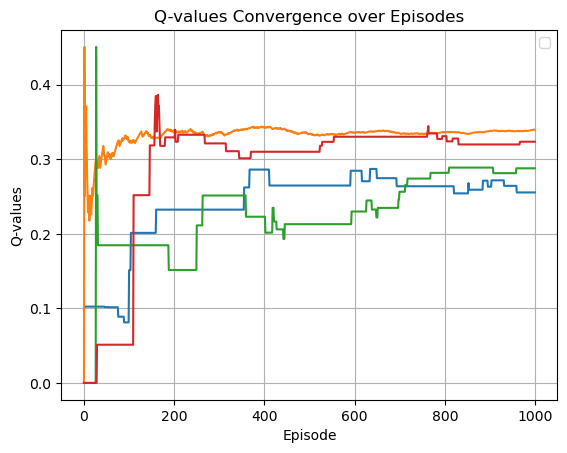

In [33]:
plt.plot(q_values_over_episodes)

plt.xlabel('Episode')
plt.ylabel('Q-values')
plt.title('Q-values Convergence over Episodes')
plt.grid(True)
plt.legend()
plt.show()


<h3> CONCLUSION </h3>

In [34]:
#Selection of Best Treatment Type based on the Q_Value
selected_treatment_types = np.argmax(mab.q_values)
print("Treatment type with highest Q-values:", env.treatment_types[selected_treatment_types])

Treatment type with highest Q-values: Harmone Therapy


Hence, we are selecting Hormone Therapy as our preferred treatment process. This is because Hormone Therapy performs better than other treatment processes via Multi-Armed Bandit Algorithm.